In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
plt.rcParams["font.size"] = 8

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
data_dir = Path('./parkinsons_dataset')
data_dir

WindowsPath('parkinsons_dataset')

In [3]:
df = pd.DataFrame({'path': list(data_dir.glob('*/*.png'))})
df['img_id'] = df['path'].map(lambda x: x.stem)
df['disease'] = df['path'].map(lambda x: x.parent.stem)
print(df.shape, 'images loaded')
df.head()

(831, 3) images loaded


,path,img_id,disease
0,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_001,normal
1,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_002,normal
2,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_003,normal
3,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_004,normal
4,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_005,normal


In [4]:
df['path'] = df['path'].apply(lambda x: Path(x))

def extract_prefix(file_path):
    prefix = file_path.stem.rsplit('_', 1)[0]
    return prefix

df['label'] = df['path'].apply(extract_prefix)
df

,path,img_id,disease,label
0,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_001,normal,ep2d_diff_3scan_trace_p2_ADC_DFC
1,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_002,normal,ep2d_diff_3scan_trace_p2_ADC_DFC
2,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_003,normal,ep2d_diff_3scan_trace_p2_ADC_DFC
3,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_004,normal,ep2d_diff_3scan_trace_p2_ADC_DFC
4,parkinsons_dataset\normal\ep2d_diff_3scan_trac...,ep2d_diff_3scan_trace_p2_ADC_DFC_005,normal,ep2d_diff_3scan_trace_p2_ADC_DFC
...,...,...,...,...
826,parkinsons_dataset\parkinson\T2W_TSE_014.png,T2W_TSE_014,parkinson,T2W_TSE
827,parkinsons_dataset\parkinson\T2W_TSE_015.png,T2W_TSE_015,parkinson,T2W_TSE
828,parkinsons_dataset\parkinson\T2W_TSE_016.png,T2W_TSE_016,parkinson,T2W_TSE
829,parkinsons_dataset\parkinson\T2W_TSE_017.png,T2W_TSE_017,parkinson,T2W_TSE


In [5]:
df['label'].value_counts()

label
t1_fl3d_sag_p4_iso_1.0                 176
Mag_Images                              72
Pha_Images                              72
SWI_Images                              72
mIP_Images(SW)                          65
ep2d_diff_3scan_trace_p2_TRACEW_DFC     60
DUAL_TSE                                44
sDW_SSh                                 44
Reg_-_sDW_SSh_SENSE                     44
ep2d_diff_3scan_trace_p2_ADC_DFC        30
t2_tse_tra                              30
t2_tirm_tra_dark-fluid                  30
dReg_-_sDW_SSh_SENSE                    22
T1W_FFE                                 22
T2W_FLAIR                               22
T2W_TSE                                 18
Survey_SHC                               5
localizer                                3
Name: count, dtype: int64

In [6]:
df.nunique()

path       831
img_id     831
disease      2
label       18
dtype: int64

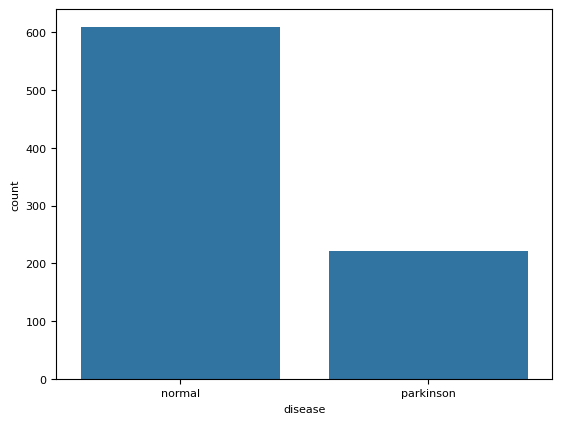

In [7]:
sns.countplot(df, x='disease')
plt.show()

## TRAIN TEST SPLIT

In [8]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(664,) (664,)
(167,) (167,)


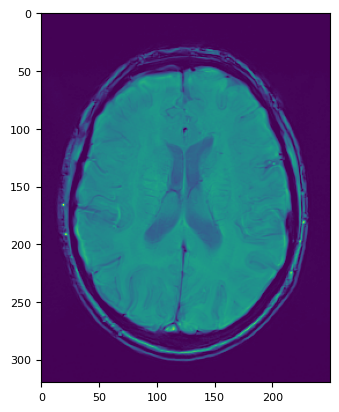

(320, 250)

In [10]:
image = plt.imread(X_train.iloc[1])
plt.imshow(image)
plt.show()

image.shape

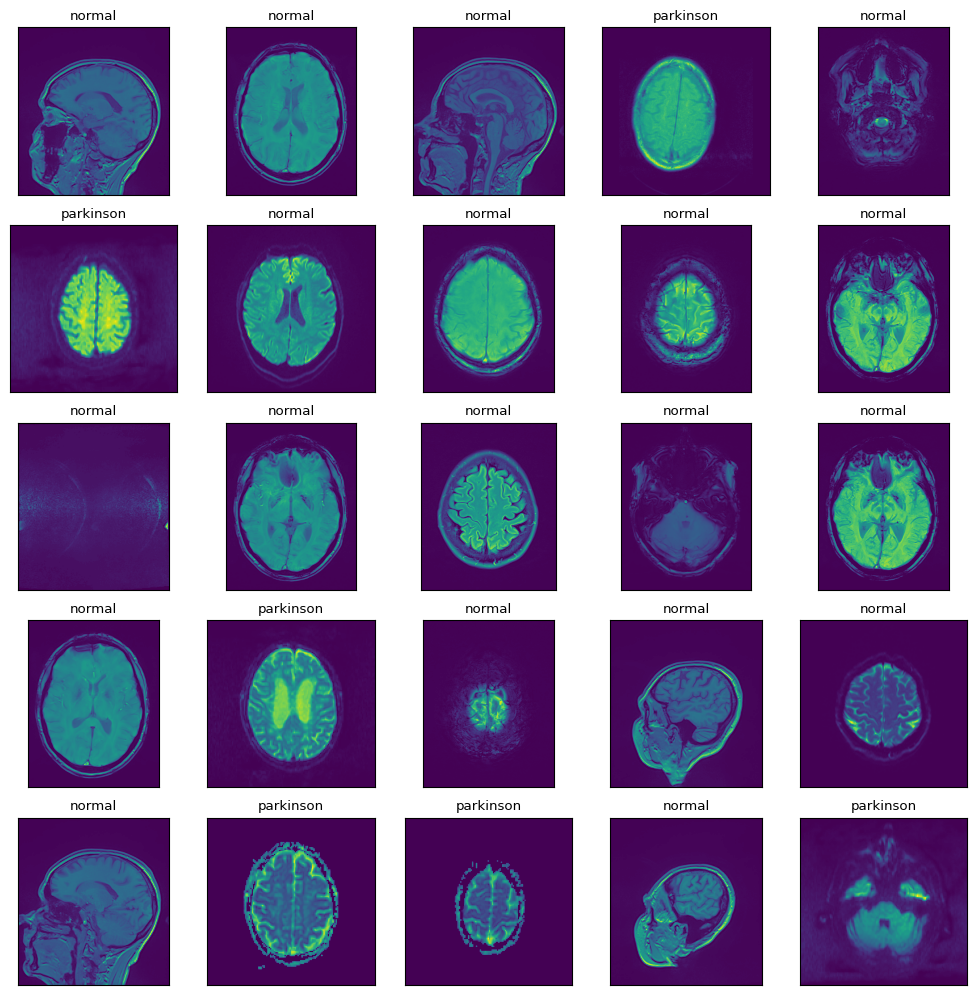

In [11]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(X_train.iloc[i]))
    ax.set_title(y_train.iloc[i])
plt.tight_layout()
plt.show()

## TrainDATA

In [12]:
trainData = pd.DataFrame({'path':X_train, 'disease':y_train})
trainData.loc[:, 'path'] = trainData['path'].astype(str)

# train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainData,
    x_col='path',         
    y_col='disease',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='binary'
)

Found 664 validated image filenames belonging to 2 classes.


## TestDATA

In [13]:
testData = pd.DataFrame({'path':X_test, 'disease':y_test})
testData.loc[:, 'path'] = testData['path'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testData,
    x_col='path',         
    y_col='disease',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='binary'
)

Found 167 validated image filenames belonging to 2 classes.


# MODEL TRAINING

In [14]:
def loss_history_plot(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [15]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam

In [16]:
def train_model(base_model):
    for layer in base_model.layers[:-5]:
            layer.trainable = False
    
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
#     top_model = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    
#     new_learning_rate = 0.0001 
#     custom_optimizer = Adam(learning_rate=new_learning_rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    
    history = model.fit(train_generator, epochs=10, validation_data=test_generator, batch_size = 10)
    
    return model, history

# VGG 16

In [17]:
from keras.applications import VGG16
from tensorflow.keras import regularizers

In [18]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 198s 3us/step


In [19]:
model, history = train_model(VGG)

Epoch 1/10


c:\Users\Umair\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 372s 17s/step - accuracy: 0.6548 - loss: 1.0100 - val_accuracy: 0.6707 - val_loss: 0.7784
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 356s 17s/step - accuracy: 0.7609 - loss: 0.5116 - val_accuracy: 0.8802 - val_loss: 0.3394
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 353s 17s/step - accuracy: 0.8706 - loss: 0.3197 - val_accuracy: 0.8862 - val_loss: 0.2454
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 337s 16s/step - accuracy: 0.9056 - loss: 0.2537 - val_accuracy: 0.8922 - val_loss: 0.4983
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 359s 17s/step - accuracy: 0.9221 - loss: 0.2437 - val_accuracy: 0.9521 - val_loss: 0.1375
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 350s 16s/step - accuracy: 0.9544 - loss: 0.1063 - val_accuracy: 0.9461 - val_loss: 0.1516
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 346s 16s/step - accuracy: 0.9819 - loss: 0.0525 - val_accuracy: 0.9341 - val_loss: 0.1657
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 347s 16s/step - accuracy: 0.9438 - loss: 0.1352 - val_accuracy: 0.9641 - val_

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,948,805 (110.43 MB)

 Trainable params: 7,104,513 (27.10 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,209,028 (54.20 MB)

In [21]:
predictions = model.predict(test_generator)
predictions = [1 if x>0.5 else 0 for x in predictions]
true_labels = test_generator.classes
confusion_mtx = confusion_matrix(true_labels, predictions) 
confusion_mtx

6/6 ━━━━━━━━━━━━━━━━━━━━ 62s 10s/step


array([[68, 44],
       [37, 18]], dtype=int64)

In [22]:
accuracy = accuracy_score(true_labels, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.51


In [23]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to preprocess the input image
def preprocess_input_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

# Function to make predictions
def predict_disease(image_path, model):
    processed_image = preprocess_input_image(image_path)
    prediction = model.predict(processed_image)
    if prediction[0][0] > 0.5:
        return "Parkinson's Disease"
    else:
        return "Healthy"

# Path to the input image
input_image_path = './parkinsons_dataset\\normal\\ep2d_diff_3scan_trace_p2_ADC_DFC_013.png'  # Replace 'path_to_input_image' with the actual path to your input image

# Predict disease
predicted_disease = predict_disease(input_image_path, model)
print("Predicted Disease:", predicted_disease)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Disease: Healthy


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


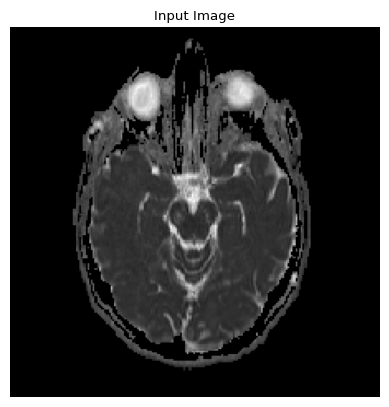

Predicted Disease: Healthy
Confidence: 100.0%


In [24]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the input image
def preprocess_input_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img, img_array

# Function to make predictions
def predict_disease(image_path, model):
    processed_image = preprocess_input_image(image_path)
    prediction = model.predict(processed_image[1])
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    disease = "Parkinson's Disease" if prediction[0][0] > 0.5 else "Healthy"
    return disease, confidence, processed_image[0]

# Path to the input image
input_image_path = './parkinsons_dataset\\normal\\ep2d_diff_3scan_trace_p2_ADC_DFC_013.png'  # Replace 'path_to_input_image' with the actual path to your input image

# Predict disease
predicted_disease, confidence, input_image = predict_disease(input_image_path, model)

# Display the input image
plt.imshow(input_image)
plt.title('Input Image')
plt.axis('off')
plt.show()

# Print the predicted disease and confidence score
print("Predicted Disease:", predicted_disease)
print("Confidence:", str(confidence * 100) + '%')


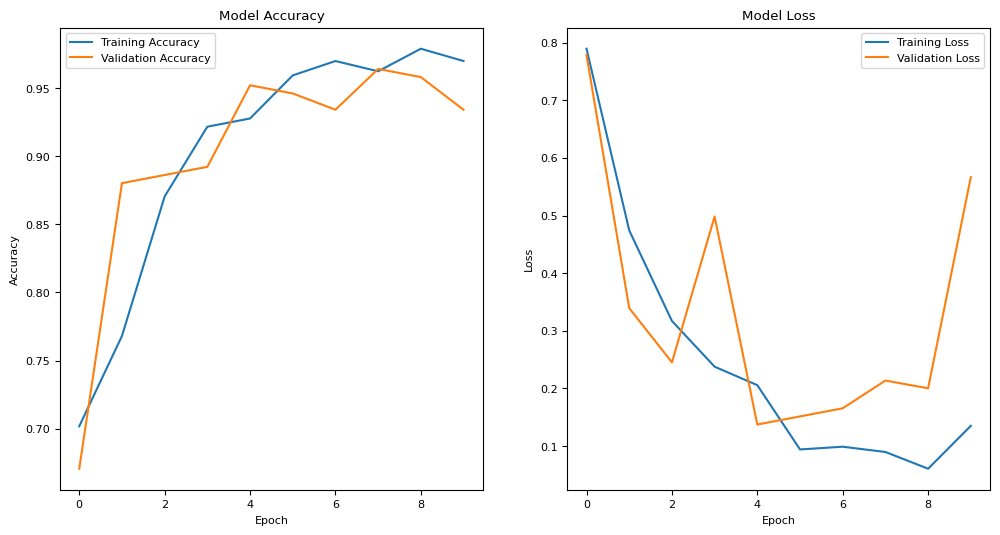

In [25]:
loss_history_plot(history)

In [26]:
model.save("tensorflow_model1.h5")

# RESNET50

# InceptionV3

# MobileNetV2